### Описание проекта
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

### Содержание <a id='contents'></a>

1. [Шаг 1. Загрузите данные](#step1)<br>
    <br>
2. [Шаг 2. Проведите исследовательский анализ данных (EDA)](#step2)
    * [Проверка датасета на отсутствующие признаки, средние значения и стандартные отклонения](#step2.1)
    * [Средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался](#step2.2)
    * [Построение столбчатых гистограмм и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)](#step2.3) 
    * [Матрица корреляции](#step2.4)
    * [Вывод](#step2.5)<br>
    <br>
3. [Шаг 3. Построение модели прогнозирования оттока клиентов](#step3)
    * [Разбивка данных на обучающую и валидационную выборки](#step3.1)
    * [Обучение модели на train-выборке логистической регрессией и случайным лесом](#step3.2)
    * [Оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке. Сравнение моделей](#step3.3)
    * [Вывод](#step3.4)<br>
    <br>
4. [Шаг 4. Кластеризация клиентов](#step4)
    * [Стандартизация данных](#step4.1)
    * [Построение матрицы расстояний функцией linkage() на стандартизованной матрице признаков и отрисовка дендрограммы ](#step4.2)
    * [Обучение модели кластеризации на основании алгоритма K-Means и прогноз кластеров клиентов](#step4.3)
    * [Изучение средних значений признаков для кластеров. Характерные особенности](#step4.4)
    * [Распределение признаков для кластеров](#step4.5)
    * [Расчет доли оттока для каждого полученного кластера. Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?](#step4.6) <br>
    <br>
5. [Шаг 5. Выводы и базовые рекомендации по работе с клиентами](#step5)

### Шаг 1. Загрузка данных <a id='step1'></a>
[К содержанию](#contents)

Установим новую версию seaborn для применения displot:

После установки нужно перезапустить Kernel (по крайней мере у меня только так заработало))

In [1]:
!pip install seaborn --upgrade

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 283 kB 2.8 MB/s eta 0:00:01


Импортируем необзодимые библиотеки и настройки:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style = 'whitegrid', rc = {'figure.figsize':(14,10)})
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
#проверка версии seaborn
sns.__version__

'0.11.0'

In [4]:
gym_data = pd.read_csv('/datasets/gym_churn.csv')
gym_data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


Набор данных включает следующие поля:
- 'Churn' — факт оттока в текущем месяце;

Текущие поля в датасете:

Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент в таком случае фитнес-центр хранит информацию о работодателе клиента);
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).


Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

Изменим названия столбцов:

In [5]:
#приведем названия столбцов к нижнему регистру при помощи метода str.lower
gym_data.columns = gym_data.columns.str.lower()

In [6]:
#проверим новые названия столбцов
gym_data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

### Вывод

Исмортированы необходимые библиотеки и применены нужные настройки для дальнейшей работы. Исходные данные загружены в датафрейм gym_data. Названия признаков приведены к нижнему регистру.

### Шаг 2. Проведение исследовательского анализ данных (EDA) <a id='step2'></a>
[К содержанию](#contents)

#### Проверка датасета на отсутствующие признаки, средние значения и стандартные отклонения <a id='step2.1'></a>

Изучим общую информацию о полученном датафрейме:

In [7]:
#применим к датафрейму метод info
gym_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Проверим датафрейм на дубликаты:

In [8]:
gym_data.duplicated().sum()

0

На первый взгляд все столбцы имеют корректный формат данных, пропущенных значений не обнаружено.

Премениму функцию describe() для изучения средних значений и стандартного отклонения признаков.

In [9]:
gym_data.describe().T\
    .assign(out=lambda row: 2.5*row['75%'] - 1.5*row['25%'])

,count,mean,std,min,25%,50%,75%,max,out
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00,2.50
near_location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00,1.00
partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00,2.50
promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00,2.50
phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00,1.00
contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00,13.50
group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00,2.50
age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00,37.00
avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59,424.07
month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00,13.50


Избавимся от выбросов. За выбросы будем считать значения, превосходящие третий квартиль на полтора межквартильных размаха.

In [10]:
gym_data = gym_data.query('avg_additional_charges_total < 425 & avg_class_frequency_total < \
                          5 & avg_class_frequency_current_month < 5 & month_to_end_contract < 11')
gym_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3268 entries, 0 to 3998
Data columns (total 14 columns):
gender                               3268 non-null int64
near_location                        3268 non-null int64
partner                              3268 non-null int64
promo_friends                        3268 non-null int64
phone                                3268 non-null int64
contract_period                      3268 non-null int64
group_visits                         3268 non-null int64
age                                  3268 non-null int64
avg_additional_charges_total         3268 non-null float64
month_to_end_contract                3268 non-null float64
lifetime                             3268 non-null int64
avg_class_frequency_total            3268 non-null float64
avg_class_frequency_current_month    3268 non-null float64
churn                                3268 non-null int64
dtypes: float64(4), int64(10)
memory usage: 383.0 KB


#### Средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался <a id='step2.2'></a>

Сгруппируем датафрейм gym_data по оттоку клиентов.

In [11]:
#метод groupby по столбцу 'churn' и средним значениям столбцов
churn_grouped = gym_data.groupby('churn').mean()
churn_grouped

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.86,0.48,0.32,0.91,3.84,0.44,29.99,152.53,3.31,4.74,2.03,2.03
1,0.51,0.77,0.35,0.18,0.90,1.56,0.27,27.01,114.70,1.50,0.99,1.47,1.04


В среднем меньше уходят клиенты близко живущие, приведенные друзьями, с длительными абонементами, чаще посещающие зал и тратящие больше денег.

#### Построение столбчатых гистограмм и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток) <a id='step2.3'></a>

Построим столбчатые диаграммы для бинарных признаков:

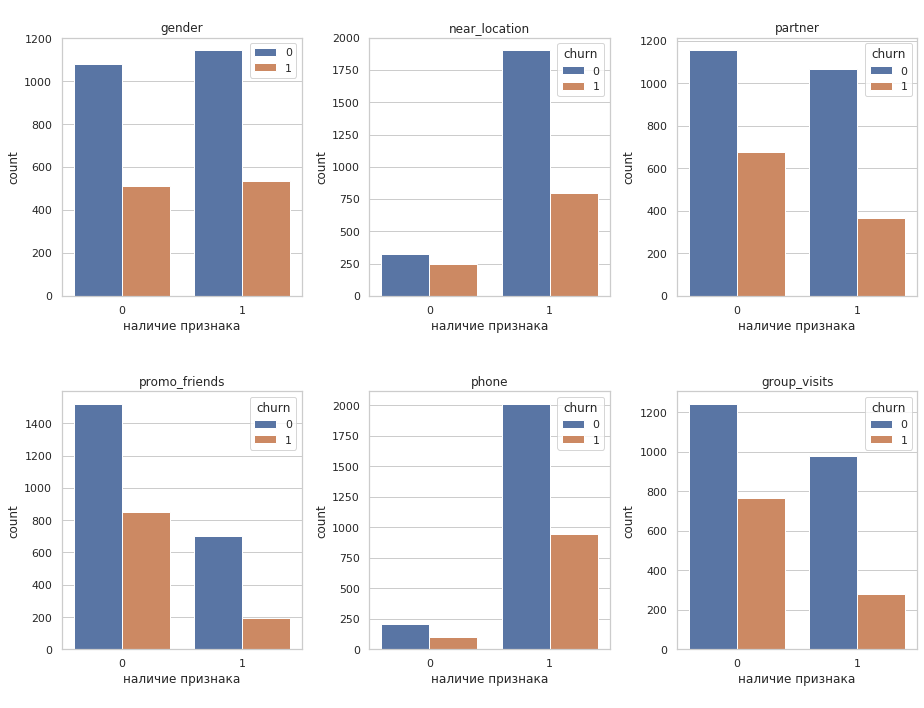

In [12]:
plt.subplots(figsize=(13,10))
num_cols = 3
num_rows = 2

for i, col in enumerate(['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']):
    sns.countplot(x = gym_data[col], hue = 'churn', data = gym_data, ax = plt.subplot(num_rows, num_cols, i+1))
    plt.title('\n' + col)
    plt.xlabel('наличие признака' + '\n')
    plt.tight_layout()
    if i == 0: plt.legend()

Построим распределения для числовых признаков:

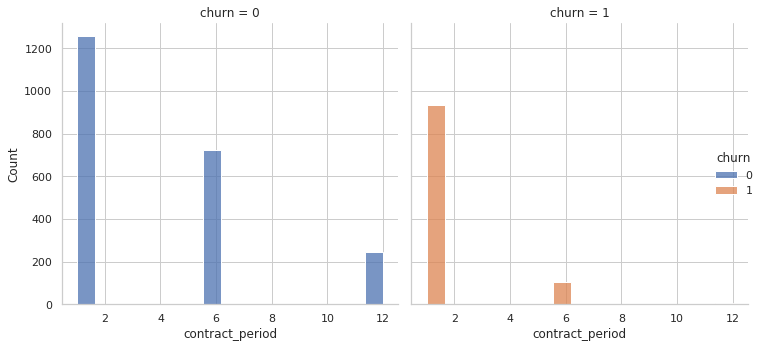

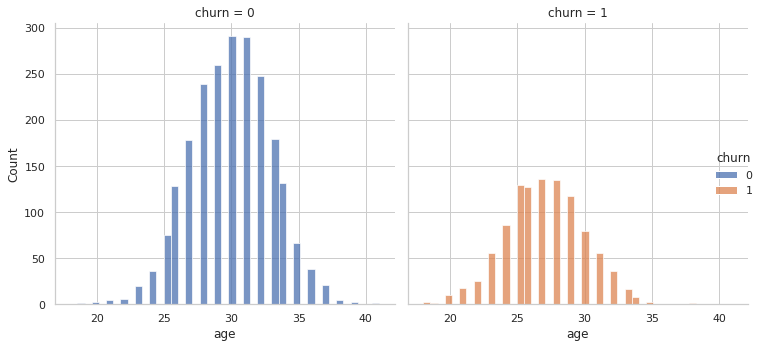

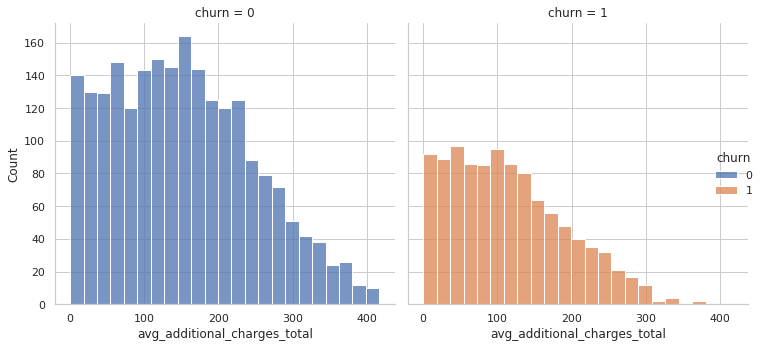

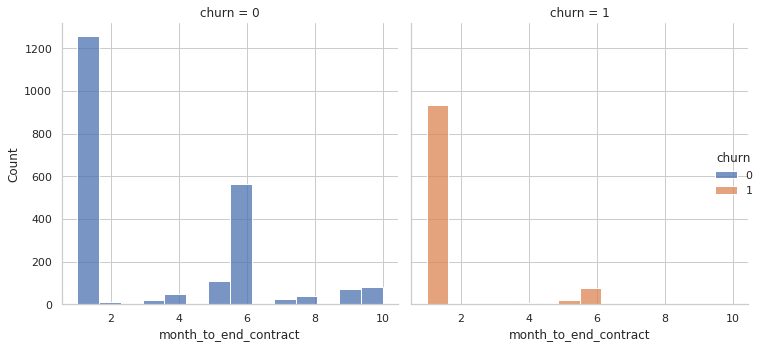

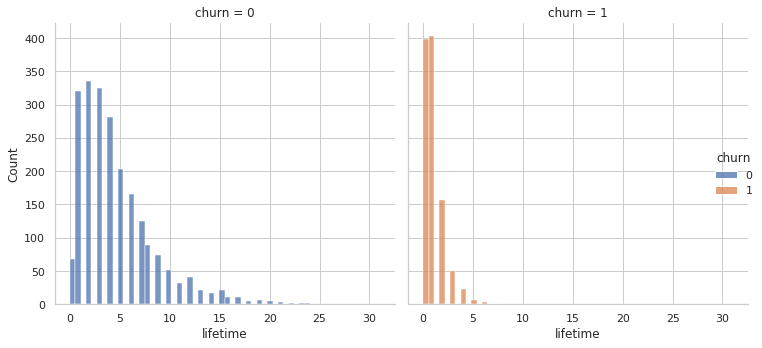

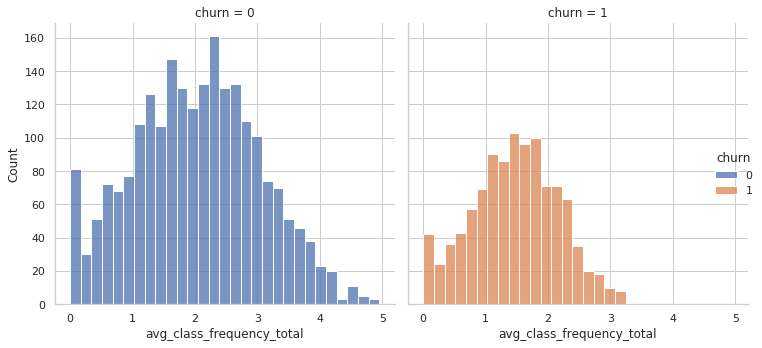

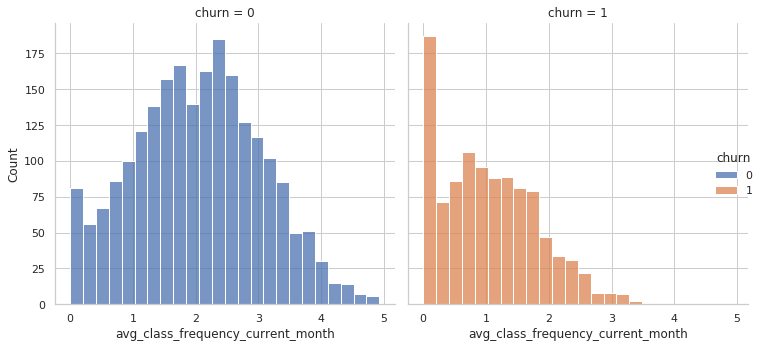

In [13]:
for cols in ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 
                         'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    sns.displot(x = gym_data[cols], col = 'churn', data = gym_data, hue = 'churn')
    plt.tight_layout()

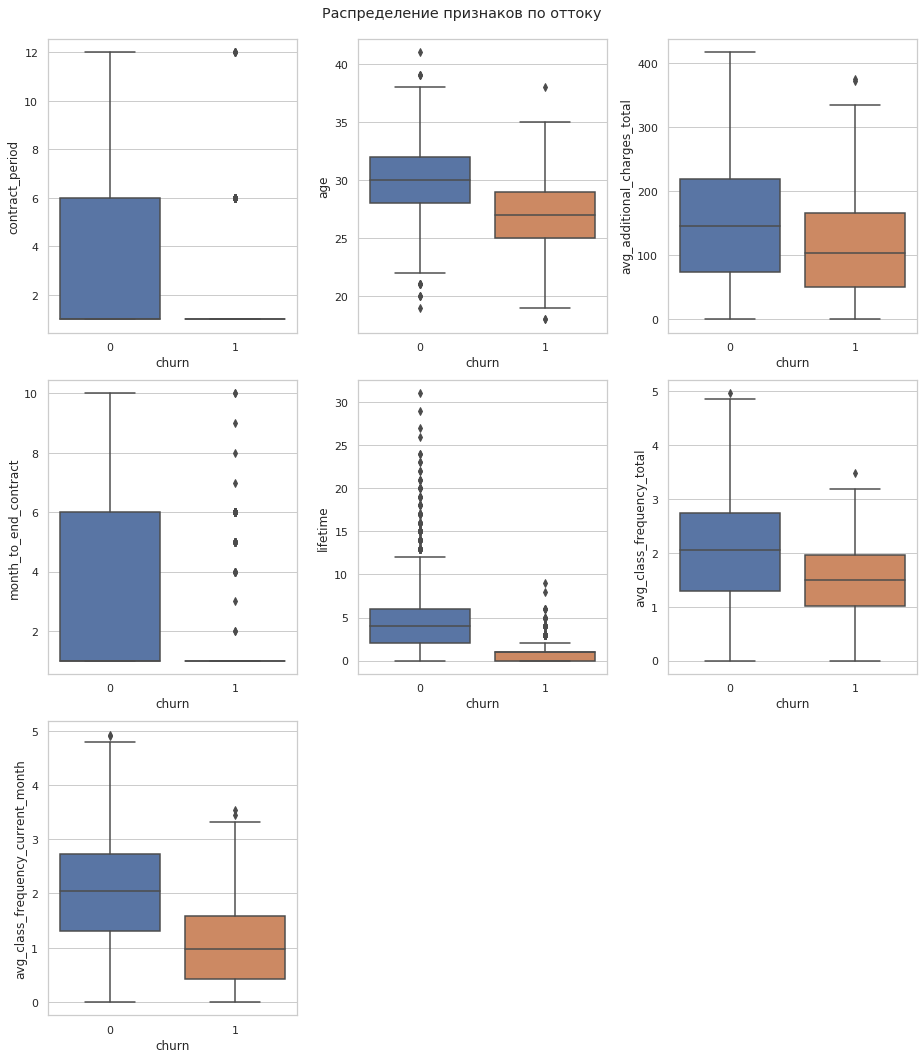

In [14]:
plt.subplots(figsize=(13,15))
plt.suptitle('Распределение признаков по оттоку')
num_cols = 3
num_rows = 3

for i, col in enumerate(['contract_period','age','avg_additional_charges_total', 'month_to_end_contract', 
                         'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']):
    sns.boxplot(x = 'churn', data = gym_data, y = gym_data[col], ax = plt.subplot(num_rows, num_cols, i+1))
    plt.tight_layout()
    plt.subplots_adjust(top = 0.95)

Построенные диаграммы подтверждают сделанные ранее выводы, основанные на средних признаках сгруппированного датафрейма.
Реже уходят клиенты близко живущие, приведенные друзьями, с длительными абонементами, чаще посещающие зал и тратящие больше денег. Также средний возраст клиентов из группы оттока несколько ниже. Видимо, молодые еще не нашли то, что ищут и пробуют что-то новое. Возможно, что сам зал по каким-то параметрам больше подходит более взрослым.

#### Матрица корреляции <a id='step2.4'></a>

Построим матрицу корреляции и тепловую карту матрицы для датафрейма gym_data:

In [15]:
g_corr = gym_data.corr()
g_corr

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.00,0.00,-0.00,0.00,-0.00,0.01,0.02,0.01,0.00,0.01,0.02,0.03,0.02,-0.00
near_location,0.00,1.00,-0.03,0.20,-0.02,0.12,0.15,0.05,0.04,0.11,0.08,0.05,0.06,-0.11
partner,-0.00,-0.03,1.00,0.44,0.02,0.25,0.01,0.03,0.01,0.24,0.05,0.01,0.03,-0.12
promo_friends,0.00,0.20,0.44,1.00,0.00,0.20,0.10,0.05,0.03,0.20,0.07,0.03,0.05,-0.14
phone,-0.00,-0.02,0.02,0.00,1.00,0.00,-0.01,-0.01,0.02,-0.01,-0.02,-0.00,0.00,-0.00
contract_period,0.01,0.12,0.25,0.20,0.00,1.00,0.14,0.12,0.08,0.95,0.16,0.11,0.16,-0.32
group_visits,0.02,0.15,0.01,0.10,-0.01,0.14,1.00,0.08,0.02,0.13,0.06,0.07,0.08,-0.17
age,0.01,0.05,0.03,0.05,-0.01,0.12,0.08,1.00,0.08,0.12,0.19,0.13,0.20,-0.42
avg_additional_charges_total,0.00,0.04,0.01,0.03,0.02,0.08,0.02,0.08,1.00,0.08,0.08,0.05,0.08,-0.19
month_to_end_contract,0.01,0.11,0.24,0.20,-0.01,0.95,0.13,0.12,0.08,1.00,0.15,0.10,0.15,-0.32


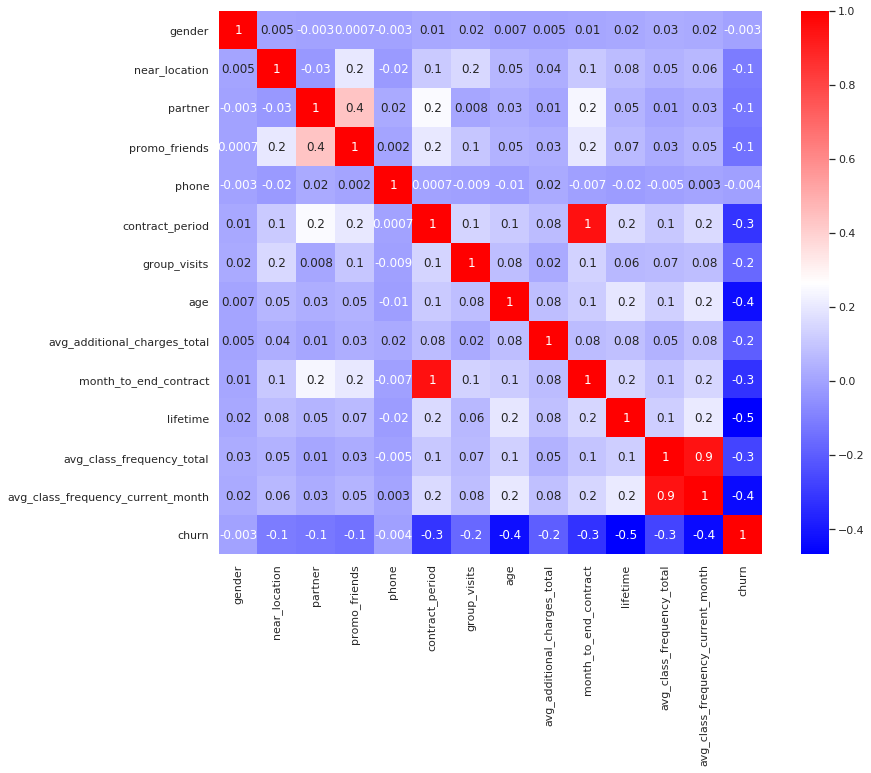

In [16]:
sns.heatmap(g_corr, square = True, annot = True, fmt = '.1g', cmap = 'bwr');

Видим сильно коррелирующие между собой признаки 'avg_class_frequency_total' и 'avg_class_frequency_current_month'. При построении модели можно избавиться от одного из них. Но алгоритмы сами выбирают кол-во используемых признаков, поэтому оставим признак на месте.

### Вывод <a id='step2.5'></a>

Были изучены признаки датасета, средние значения и стандартное отклонение. Удалены выбросы. За выбросы приняты значения, превосходящие третий квартиль признака на полтора межквартильных размаха. <br>
Построены столбчатые графики для бинарных признаков и диаграммы распределения для числовых. По построенным диаграммам можно сделать вывод, что реже уходят клиенты близко живущие, приведенные друзьями, с длительными абонементами, чаще посещающие зал и тратящие больше денег. Также средний возраст клиентов из группы оттока несколько ниже.

### Шаг 3. Построение модели прогнозирования оттока клиентов <a id='step3'></a>
[К содержанию](#contents)

#### Разбивка данных на обучающую и валидационную выборки <a id='step3.1'></a>

Разделим данные на выборки при помощи функции train_test_split:

In [17]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_data.drop(columns = ['churn'])
y = gym_data['churn']

# разделяем модель на обучающую и валидационную выборку, соотношение обучающей/валидационной выборок: 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#### Обучение модели на train-выборке логистической регрессией и случайным лесом <a id='step3.2'></a>

Создадим список с алгоритмами для построения модели и их параметрами:

In [18]:
models = [LogisticRegression(random_state = 0),
          RandomForestClassifier(random_state = 0, n_estimators = 20, max_depth = 10, max_features = 8,
                                n_jobs = -1)]

Напишем функцию, выводящую метрики для моделей, построенных разными алгоритмами:

In [19]:
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    #обучим модель 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f} F1:{:.2f}'.format(accuracy_score(y_test, y_pred),
                                                                     precision_score(y_test, y_pred),
                                                                   recall_score(y_test, y_pred),
                                                                           f1_score(y_test, y_pred)))

#### Оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке. Сравнение моделей <a id='step3.3'></a>

In [20]:
for i in models:
    print(i)
    print()
    make_prediction(i, X_train, y_train, X_test, y_test)
    report = classification_report(y_test, i.predict(X_test))
    print(report)
    print()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy:0.92 Precision:0.87 Recall:0.86 F1:0.86
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       460
           1       0.87      0.86      0.86       194

    accuracy                           0.92       654
   macro avg       0.90      0.90      0.90       654
weighted avg       0.92      0.92      0.92       654


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
           

Проверим, возможно, стандартизация данных повысит точность модели:

In [21]:
#созддим объект класса scaler (стандартизатор)
scaler = StandardScaler() 
#обучим scaler и трансформируем матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train) 
X_test_st = scaler.transform(X_test)

for i in models:
    print(i)
    print()
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)
    report = classification_report(y_test, i.predict(X_test_st))
    print(report)
    print()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy:0.92 Precision:0.86 Recall:0.86 F1:0.86
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       460
           1       0.86      0.86      0.86       194

    accuracy                           0.92       654
   macro avg       0.90      0.90      0.90       654
weighted avg       0.92      0.92      0.92       654


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
           

Случайный лес имеет более высокие метрики, для работы рекомендуется использовать ее. Модель на данных до стандартизации и после нее показали сравнимый результат.

### Вывод <a id='step3.4'></a>

Были построены модели по алгоритмам Случайного леса и Логистической регрессии. Сравнены модели, построенные на исходных очищенных данных и стандартизованных данных. Исходные данные показали более высокий результат. В качестве более точного выбран алгоритм Случайного леса (Random Forest), показавший высокие результаты метрик (Accuracy: 0.92, Precision: 0.87, Recall: 0.87, F1: 0.87). <br>
Проведена попытка повысить точность выбранной модели автоматизированным подбором параметров. Полученные параметры снизили точность предсказания. Принято решение применять исходную модель.

### Шаг 4. Кластеризация клиентов <a id='step4'> </a>
[К содержанию](#contents)

#### Стандартизация данных <a id='step4.1'></a>

Проведем стандартизацию данных при помощи функции StandartScaler():

In [23]:
#создаём объект класса scaler (нормализатор)
scaler = StandardScaler()
x_sc = scaler.fit_transform(gym_data.drop(columns = ['churn']))
x_sc

array([[ 0.9734252 ,  0.45621605,  1.13160521, ..., -0.14487414,
        -1.91484194, -1.63560463],
       [-1.0273003 ,  0.45621605,  1.13160521, ..., -0.41311704,
         0.0061823 ,  0.01737877],
       [ 0.9734252 ,  0.45621605,  1.13160521, ..., -0.14487414,
        -0.772397  , -0.5693976 ],
       ...,
       [ 0.9734252 ,  0.45621605, -0.88370042, ..., -0.68135993,
        -0.72688029, -1.37897452],
       [-1.0273003 ,  0.45621605, -0.88370042, ..., -0.68135993,
        -0.60180242, -1.35683105],
       [-1.0273003 ,  0.45621605,  1.13160521, ..., -0.14487414,
        -0.23306045, -0.11614031]])

#### Построение матрицы расстояний функцией linkage() на стандартизованной матрице признаков и отрисовка дендрограммы <a id='step4.2'></a>

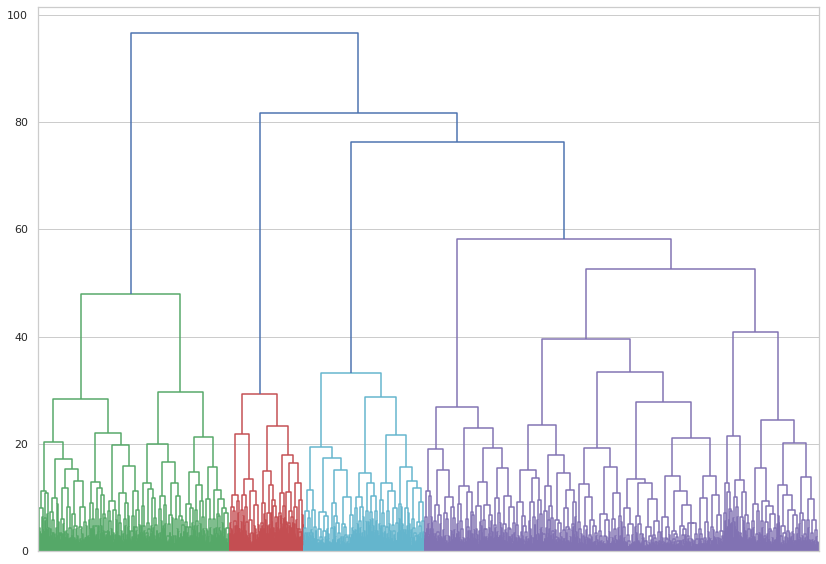

In [24]:
linked = linkage(x_sc, method = 'ward')
plt.figure()  
dendrogram(linked, orientation = 'top')
plt.xticks([])
plt.show() 

Алгоритм выдал нам 4 кластера, но, так как четвертый кластер довольно объемный, зададим для наших расчетов число кластеров равное 5.

#### Обучение модели кластеризации на основании алгоритма K-Means и прогноз кластеров клиентов <a id='step4.3'></a>

In [25]:
km = KMeans(n_clusters = 5, random_state = 0, n_init = 1) # задаём число кластеров, равное 5
labels = km.fit_predict(x_sc) # применяем алгоритм к данным и формируем вектор кластеров 
gym_data['cluster'] = labels
gym_data['cluster'].value_counts()

0    1048
2     735
1     511
3     499
4     475
Name: cluster, dtype: int64

Получили 5 кластеров, четвертый кластер - самый объемный, нулевой - самый маленький. Далее рассмотрим характерные особенности по кластерам.

#### Изучение средних значений признаков для кластеров. Характерные особенности <a id='step4.4'></a>

In [26]:
#получим сводную таблицу методом groupby по средним значения признаков
clusters_group = gym_data.groupby('cluster').mean().T
clusters_group

cluster,0,1,2,3,4
gender,0.47,0.54,0.56,0.50,0.52
near_location,1.00,0.92,0.98,0.00,0.98
partner,0.34,0.61,0.33,0.46,0.63
promo_friends,0.23,0.43,0.27,0.07,0.44
phone,0.91,0.91,0.90,0.91,0.88
contract_period,1.04,7.95,1.05,1.77,7.10
group_visits,0.32,0.52,0.46,0.19,0.48
age,27.94,29.87,30.19,28.46,29.41
avg_additional_charges_total,125.81,161.37,154.71,129.34,139.88
month_to_end_contract,1.02,6.59,1.02,1.69,6.12


Можно заметить, что самый большой первый кластер имеет самый высокий коэффициент оттока. Алгоритм сработал хорошо, так как большая часть уходящих клиентов попала в два кластера. Первый, второй и четвертый кластеры имеют низкий коэффициент оттока, их объединяет несколько более высокий возраст по сравнению с отсальными кластерами, долгим уровнем членства в клубе и большой частотой посещения. Также можно заметить, что в отточных нулевом и третьем кластерах самый низкий средний возраст клиентов.

#### Распределение признаков для кластеров <a id='step4.5'></a>

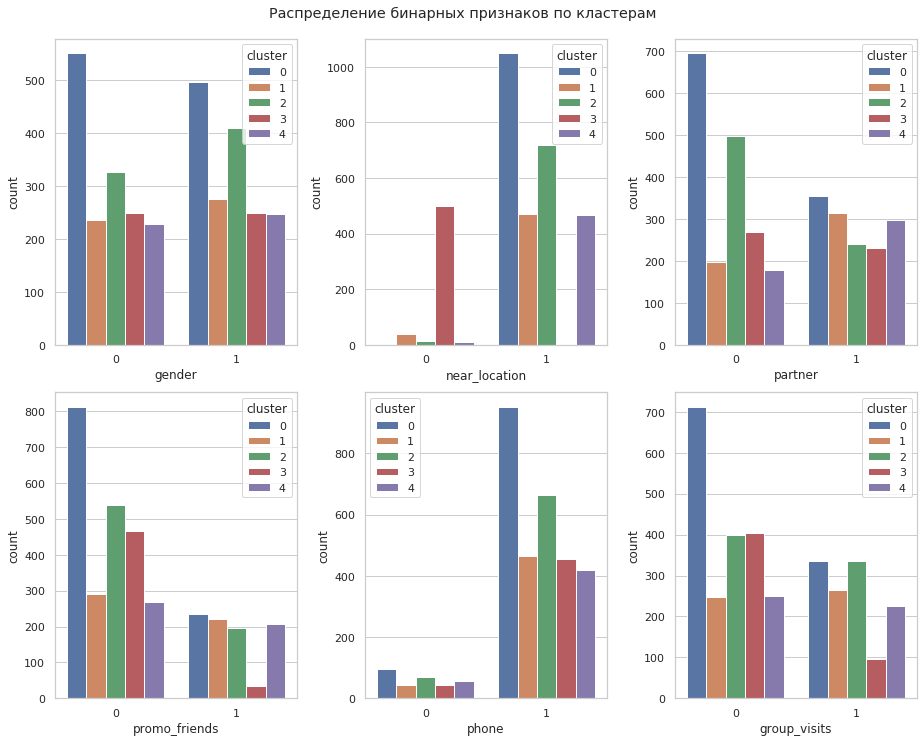

In [27]:
plt.subplots(figsize=(13,15))
plt.suptitle('Распределение бинарных признаков по кластерам')
num_cols = 3
num_rows = 3

for i, col in enumerate(['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']):
    sns.countplot(data = gym_data, x = col, hue = 'cluster', ax = plt.subplot(num_rows, num_cols, i+1))
    plt.tight_layout()
    plt.subplots_adjust(top = 0.95)

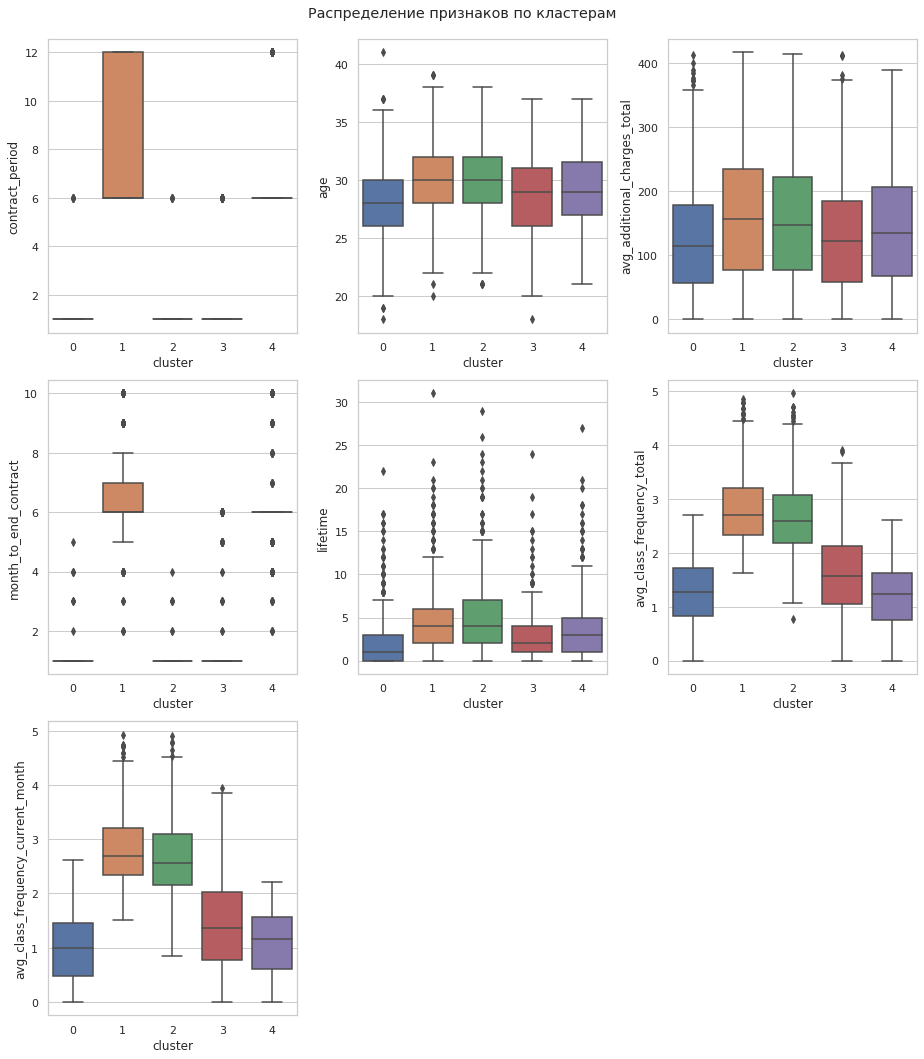

In [28]:
plt.subplots(figsize=(13,15))
plt.suptitle('Распределение признаков по кластерам')
num_cols = 3
num_rows = 3

for i, col in enumerate(['contract_period','age','avg_additional_charges_total', 'month_to_end_contract', 
                         'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']):
    sns.boxplot(data = gym_data, x = 'cluster', y = gym_data[col], ax = plt.subplot(num_rows, num_cols, i+1))
    plt.tight_layout()
    plt.subplots_adjust(top = 0.95)

Можно заметить следующие особенности:
- 'gender' (пол): наименее отточные 1, 2 и 4 кластеры имеют небольшое преобладание пола 1 (насколько я понимаю - это мужской), в то время, как более отточные кластеры имеют небольшой перевес в сторону женщин. Можно сделать вывод, что женщины менее постоянны.
- 'near_location' (близкое проживание): алгоритм определил всех далеко живущих и работающих в отточный третий кластер. Остальные кластеры показывает схожий достаточно высокий показатель по этому признаку.
- 'partner' (сотрудник компании-партнера клуба): при кластеризации неоднозначное распределение - примерно одинаково низкое значение в самом отточном кластере, так и в низко отточном втором. В целом, нет характерной зависимости.
- 'promo_friends' (приведенные другом): В целом в отточных кластерах меньше приведенных другом пользователей.
- 'phone' (наличие контактного телефона): по этому кластеру алгоритм распределил всех клиентов практически поровну.
- 'group_visits' (посещение групповых занятий): в отточных кластерах самый процент посещающих групповые занятие ниже (в районе 20-30%), в остальных кластерах этот процент примерно одинаковый (45-50%).
- 'contract_period' (длительность текущего абонемента): самый низкий показатель в нулевом, третьем (отточных) и втором кластерах. Самая длинная средняя продолжительность абонемента (более 7 месяцев) -  в низко отточных первом и четвертом кластерах.
- 'age' (возраст клиентов): самый "старые" кластеры - первый, второй и четвертый (кластеры с низким оттоком). Наиболее отточные нулевой и третий - самые "молодые". Чем старше клиенты, тем ниже вероятность их ухода. 
- 'avg_additional_charges_total' (суммарная выручка от доп. услуг фитнес-центра): чем ниже отток в кластере, тем больше тратят денег клиенты. Видимо, довольные клиенты довольны во всем.
- 'month_to_end_contract' (срок окончания действующего абонемента в месяцах): более полугода в среднем до окончания контракта в наименее отточных 1 и 4 кластерах, чуть более месяца - в отточных 0 и 3. Вроде бы есть закономерность, но во втором лояльном кластере до окончания контракта еще меньше времени, чем в третьем. Видимо, клиенты из этого кластера любят использовать каждый цент вложенных денег.
- 'lifetime' (время с момента первого обращения в фитнес-центр): тут прямая связь между оттоком и временем. Чем дольше клиенты ходят в клуб, тем меньше вероятность их ухода.
- 'avg_class_frequency_total' (средня частота посещений в неделю за все время): в малоотточные первый и второй кластеры попали наиболее чаще посещающие клуб клиенты, при этом в отточных кластерах значения средние, а в четвертом кластере с низким оттоком - самые низкие. Похоже, некоторым людям для счастья достаточно одного раза в неделю.
- 'avg_class_frequency_current_month' (средня частота посещений в неделю за прошлый месяц): результаты аналогичны предыдущему пункту, но это и не удивительно. Мы помним, что корреляция между этими признаками очень высока (около 0.9).

В целом можно сделать следующие выводы:
- чем старше клиенты, чем чаще они посещают зал и тратят больше денег, тем реже они уходят. Также мужчины более постоянны и лояльны к одному месту тренировок.
- длительность абонемента не влияет прямым образом на отток. Но многие люди в течение первого месяца определяются с дальнейшими планами насчет фитнес центра.

- в нулевой, "отточный" кластер, попали большей частью женщины, с самым низким средним возрастом (28 лет), с месячным абонементом (скорее всего взятым "на пробу"), и посещающие зал около двух месяцев. Посещают зал редко (1 раз в неделю). Скорее всего, это - клиенты, которые ходят в зал "от нечго делать" или потому, что все так делают. Никаких целей и достижений перед собой не ставящие.
- в первый, наиболее "лояльный" кластер попала группа клиентов, в которой преобладают мужчины, давно посещающие зал (в среднем около 5 месяцев), с наиболее длительным абонементом (8 месяцев в среднем), самые возрастные (30 лет), готовые тратить большие средства на дополнительные услуги и участвующие в партнерской программе.
- второй, "лояльный" кластер очень похож на первый, за исключением того, что это по большей части клиенты, попавшие в клуб напрямую, поэтому срок их абонемента короткий. Возможно, им выгоднее продлевать его каждый месяц.
- третий, "отточный" кластер большей частью выделяется тем, что все его клиенты - люди далеко живущие и работающие от клуба. В этом и есть причина их оттока. Время на дорогу убивает все иные преимущества.
- четвертый, "лояльный" кластер" является почти близнецом первого, а исключением того, что контингент этого кластера редко посещает зал. Возможно, одного раза в неделю достаточно для этих людей, сликшом заняты семьей или работой. Или атлеты от природы.

#### Расчет доли оттока для каждого полученного кластера. Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны? <a id='step4.6'></a>

In [29]:
gym_data.groupby('cluster').agg({'churn':'mean'}).reset_index()

,cluster,churn
0,0,0.61
1,1,0.03
2,2,0.10
3,3,0.48
4,4,0.15


Самые надежные - первый, второй и четвертый кластеры. Явно отточный - нулевой, к тому же он самый большой по объему, что позволяет хорошо прогнозировать отточных клиентов. Также отточным можно назвать третий кластер. В целом, довольно удачная разбивка по кластерам.

### Шаг 5. Выводы и базовые рекомендации по работе с клиентами <a id='step5'></a>
[К содержанию](#contents)

Выводы:

везде есть исключения, но в общем тенденция следующая:
- чем старше клиенты, чем чаще они посещают зал, тратят больше денег и близко живут/работают, тем реже они уходят. Также мужчины более постоянны и лояльны к одному месту тренировок.
- корпоративные скидки для партнеров фитнес-центра и программа "приведи друга" также увеличивают лояльность клиентов.
- длительность абонемента не влияет прямым образом на отток. Но многие люди в течение первого месяца определяются с дальнейшими планами насчет фитнес центра.

Рекомендации:

- Маректологам для привлечения пользователей использовать портрет аудитории лояльных "хороших кластеров".
- Поддерживать так называемые "хорошие кластеры" и найти пути для удержания аудитории из отточных. К примеру добавить новые акции для женской аудитории или пустить транспорт для далеко живущих клиентов (если ресурсы это позволяют).
- Увеличить кол-во критериев для повышения точности модели предсказаний. Или добавить разделение по характеру пользования залом. Например, разделение клиентов по использованию тех или иных частей центра (бассейн, зал и др.).
- Возможно, добавить использование превентивных методов прогнозирования, до, а не после потери клиентов. Вероятно, для этого нужно расширять применение моделей обучения "без учителя".